In [133]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

In [138]:
header = ['timestamp', 'ip_type', 'source_ip', 'source_port', 'dest_ip', 'dest_port', 'conn_type', 'length']
def parse(lines,header):
    
    pattern1 = r"(\d{2}:\d{2}:\d{2}\.\d+) (IP\d*) (?:([A-z\d:\-]+|\d+\.\d+\.\d+\.\d+)).([A-z\d]+) > (?:([A-z\d:\-]+|\d+\.\d+\.\d+\.\d+)).([A-z\d]+): ([A-z]+), length (\d+)"

    df = pd.DataFrame(columns=header)
    index_df = 0

    for line in lines:
        if line in ["", "\n"]:
            continue
        line = line.replace("\n", "").strip()
        m = re.match(pattern1, line)
        if m:
            groups = m.groups()
            timestamp = groups[0]
            ip_type = groups[1]
            source_ip = groups[2]
            source_port = int(groups[3])
            dest_ip = groups[4]
            dest_port = int(groups[5])
            conn_type = groups[6]
            length = int(groups[7])
            df.at[index_df, :] = pd.Series(
                data={
                    "timestamp": timestamp,
                    "ip_type": ip_type,
                    "source_ip": source_ip,
                    "source_port": source_port,
                    "dest_ip": dest_ip,
                    "dest_port": dest_port,
                    "conn_type": conn_type,
                    "length": length
                }
            )
            index_df += 1
        else:
            print(f"NOT MATCH |{line}|")

    return df

n = 5
df_youtube = []
df_discord = []

packets = math.inf
for i in range(n):
    with open(f"data/youtube{i}.txt", "r") as f:
        df1 = parse(f.readlines(),header)
    with open(f"data/discord{i}.txt", "r") as f:
        df2 = parse(f.readlines(),header)
        
    packets = min(packets, len(df1), len(df2))
    df_youtube.append(df1)
    df_discord.append(df2)    
    
for i in range(5):
    df_youtube[i] = df_youtube[i].iloc[:packets, :]
    df_discord[i] = df_discord[i].iloc[:packets, :]
    
print(packets)

477


In [170]:
def get_flow(df, ip1, ip2):
    df_flow = pd.DataFrame(columns=["source","interval","size"])
    index_flow = 0
    
    def timestamp_to_time_ms(timestamp):
        regex1 = r"(\d{2}):(\d{2}):(\d{2}).(\d+)"
        m_regex1 = re.match(regex1, timestamp)
        groups = m_regex1.groups()
        time_s = int(groups[0]) * 3600 + int(groups[1]) * 60 + int(groups[2])
        return time_s * 1000 + (int(groups[3]) / 1000000) * 1000

    for i in range(len(df)-1):
        timestamp_i = df.loc[i, ["timestamp"]]["timestamp"]
        timestamp_i_1 = df.loc[i+1, ["timestamp"]]["timestamp"]
        
        time_ms_i = timestamp_to_time_ms(timestamp_i)
        time_ms_i_1 = timestamp_to_time_ms(timestamp_i_1)
        interval = time_ms_i_1 - time_ms_i

        source = 1 if df.loc[i, ["source_ip"]]["source_ip"] == ip1 else 2
        df_flow.at[index_flow, :] = pd.Series(
                data={
                    "source": source,
                    "interval": interval,
                    "size": df.loc[i, ["length"]]["length"]
                }
            )
        index_flow += 1
        
    return df_flow

def get_channels(df_flow):
    ch_1 = df_flow.copy()
    ch_1.loc[ch_1["source"] == 2, "interval"] = 0
    ch_1.loc[ch_1["source"] == 2, "size"] = 0
    ch_2 = df_flow.copy()
    ch_2.loc[ch_2["source"] == 1, "interval"] = 0
    ch_2.loc[ch_2["source"] == 1, "size"] = 0

    return ch_1, ch_2


def get_features(df_ch_1, df_ch_2):
    # 1 -> source is user pc, so is output
    # 2 -> source is web, so is input
    n_input = len(df_ch_2[df_ch_2["size"] != 0])
    n_output = len(df_ch_1[df_ch_1["size"] != 0])
    
    s_input =  df_ch_2["size"].sum()
    s_output =  df_ch_1["size"].sum()
    
    interval_input = df_ch_2["interval"].mean()
    interval_output = df_ch_1["interval"].mean()
    
    
    return [
        n_input,
        n_output,
        s_input,
        s_output,
        interval_input,
        interval_output
    ]

X_train = []
y_train = []


for i in range(n):
    df_flow_youtube = get_flow(df_youtube[i], "magody-pc", "2800:3f0:4005:409::200e")
    df_flow_discord = get_flow(df_discord[i], "magody-pc", "162.159.135.232")
    df_ch_youtube_1, df_ch_youtube_2 = get_channels(df_flow_youtube)
    df_ch_discord_1, df_ch_discord_2 = get_channels(df_flow_discord)
    features_youtube = get_features(df_ch_youtube_1, df_ch_youtube_2)
    features_discord = get_features(df_ch_discord_1, df_ch_discord_2)
    X_train.append(features_youtube)
    X_train.append(features_discord)
    y_train.append([1,0])
    y_train.append([0,1])

X_train = np.array(X_train)
y_train = np.array(y_train)
for i in range(7):
    X_train = np.concatenate((X_train, X_train))
    y_train = np.concatenate((y_train, y_train))
print(X_train.shape, y_train.shape)


(1280, 6) (1280, 2)


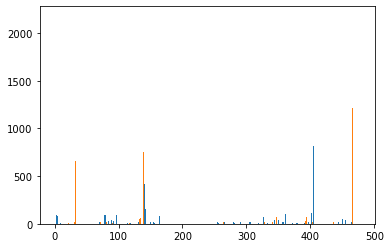

In [165]:
x_range = list(range(1,len(df_ch_youtube_1["interval"].values)+1))
plt.bar(x_range, df_ch_youtube_1["interval"].values)
plt.bar(x_range, df_ch_youtube_2["interval"].values)
plt.show()

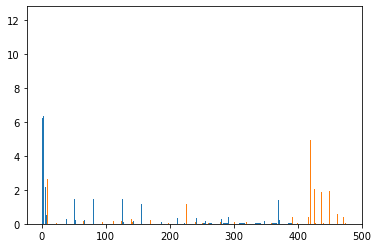

In [164]:
x_range = list(range(1,len(df_ch_discord_1["interval"].values)+1))
plt.bar(x_range, df_ch_discord_1["interval"].values)
plt.bar(x_range, df_ch_discord_2["interval"].values)
plt.show()

# Model

In [101]:
# machine learning
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import naive_bayes
from sklearn import gaussian_process
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import feature_selection
from xgboost import XGBClassifier
    
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

# Hypertunning libraries
import keras_tuner as kt
from sklearn.model_selection import StratifiedKFold, KFold

2021-12-28 18:26:54.681663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-28 18:26:54.681692: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/magody/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


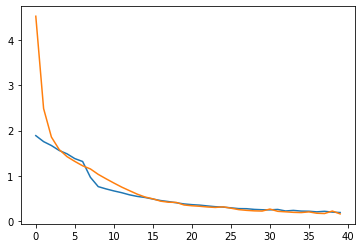

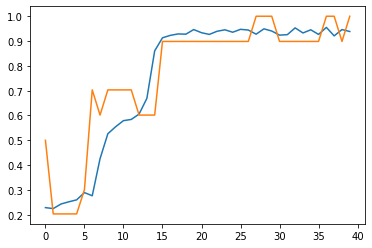

In [176]:
# Explorate the neural network
from tensorflow.keras.layers import BatchNormalization
model = Sequential(
    layers=[
        Dense(4, kernel_initializer='he_normal', activation="relu"),
        BatchNormalization(),
        Dense(2, activation="softmax")
    ]
)
adam = Adam(learning_rate=0.0005)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])

EPOCHS = 40

h = model.fit(
    X_train, 
    y_train,
    epochs=EPOCHS,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)
history = h.history
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.show()
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.show()

In [174]:
model_knn = neighbors.KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)
print(model_knn.score(X_train,y_train))

1.0
